In this notebook I use Conditional Random Fields on the [predicted masks](https://www.kaggle.com/nikhilroxtomar/u-net-dropout-augmentation-stratification). You can use it with your own submission and 
improve the score significantly by tinkering with this technique. Please refer the paper *Conditional Random Fields as Recurrent Neural Networks* for more information. Also, you may find this [repo](https://github.com/torrvision/crfasrnn) useful. Happy Kaggling :-)

In [1]:
import numpy as np
import pydensecrf.densecrf as dcrf
# from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, unary_from_softmax
# from skimage.color import gray2rgb
# from skimage.color import rgb2gray
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [2]:
def decode(rle_mask):
    # print(rle_mask)
    mask = rle_mask.split()
    # print(mask)
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)


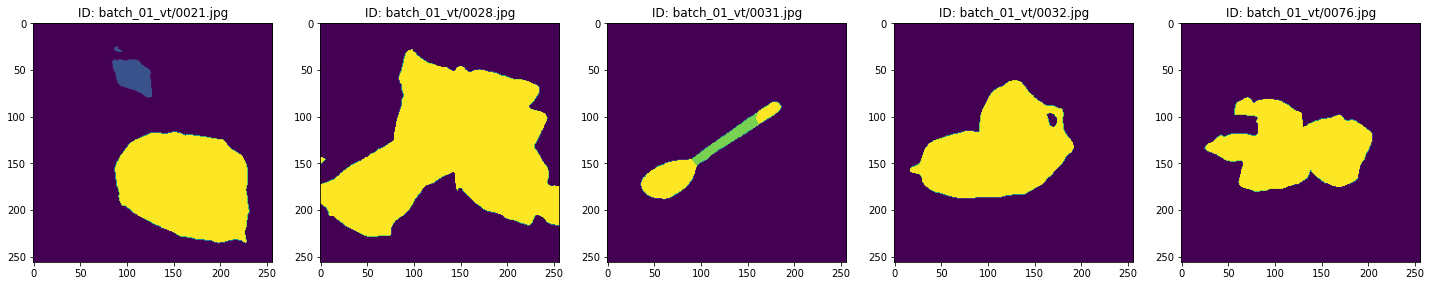

In [11]:
"""
reading and decoding the submission 

"""
df = pd.read_csv('../submission/deeplabv3_resnet101_best_model(pretrained).csv')
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
for i in range(5):      
    decoded_mask = decode(df.loc[i,'PredictionString'])
    plt.subplot(1,6,i+1)
    plt.imshow(decoded_mask)
    plt.title('ID: '+df.loc[i,'image_id'])

In [15]:
"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    labels = mask_img.flatten()

    # print(len(labels))
    n_labels = 11
    
    #Setting up the CRF model
    
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3,3), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    # im is an image-array, e.g. im.dtype == np.uint8 and im.shape == (640,480,3)
    d.addPairwiseBilateral(sxy=(10,10), srgb=(70,70,70), rgbim=original_image, compat=5)

    #Run Inference for 10 steps 
    Q = d.inference(15)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

6
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


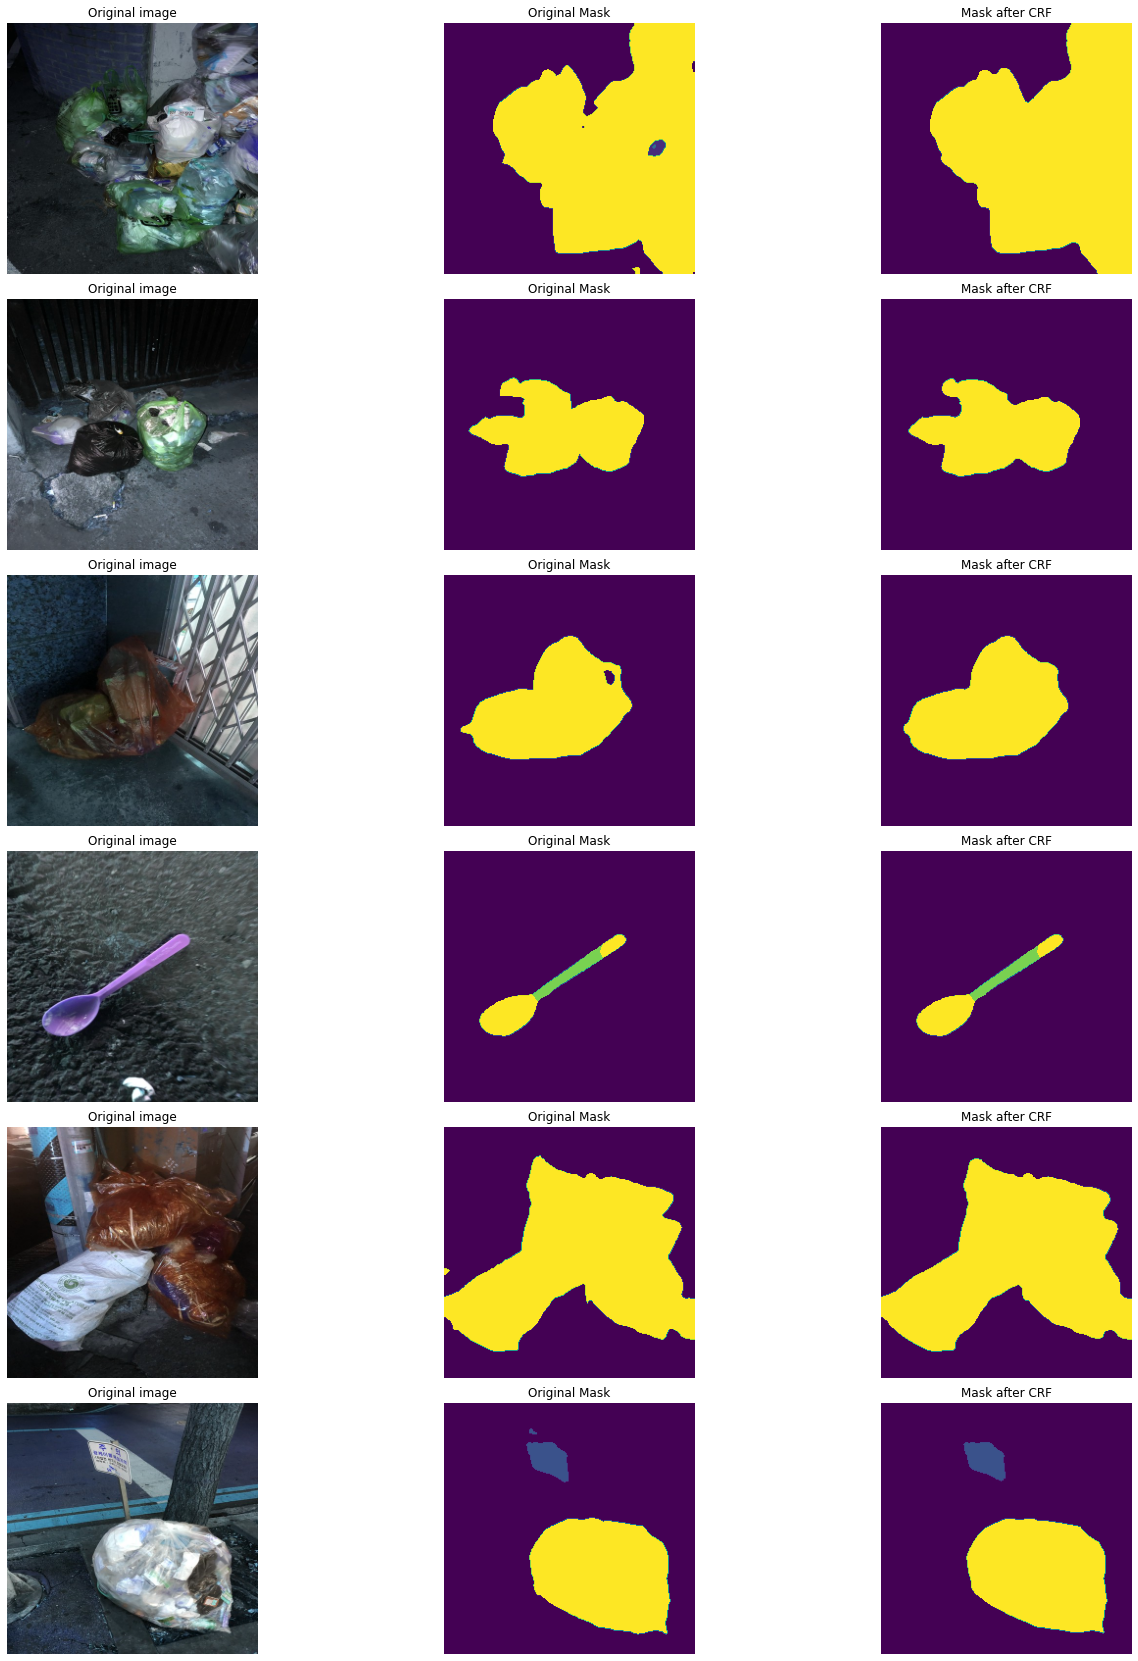

In [16]:
test_path = '/opt/ml/segmentation/input/data/'

"""
visualizing the effect of applying CRF

"""
nImgs = 6
n = np.random.randint(len(df))
n = 6
print(n)
plt.figure(figsize=(30,30))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
for i in range(1,nImgs+1): 
    decoded_mask = decode(df.loc[n-i,'PredictionString'])  
    # print(decoded_mask)      
    orig_img = cv2.imread(test_path+df.loc[n-i,'image_id'])
    orig_img = cv2.resize(orig_img, (256,256),interpolation=cv2.INTER_AREA)
    print(orig_img.shape)
    #Applying CRF on FCN-16 annotated image
    crf_output = crf(orig_img,decoded_mask)
    # print(crf_output)
    plt.subplot(nImgs,4,4*i-3)
    plt.axis('off')
    plt.imshow(orig_img)
    plt.title('Original image')
    plt.subplot(nImgs,4,4*i-2)
    plt.axis('off')
    plt.imshow(decoded_mask) 
    plt.title('Original Mask')
    plt.subplot(nImgs,4,4*i-1)
    plt.axis('off')
    plt.imshow(crf_output) 
    plt.title('Mask after CRF')
    # print(crf_output.flatten())

In [7]:
"""
used for converting the decoded image to rle mask

"""
def encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    return ' '.join(str(x) for x in pixels)

In [13]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])             
        orig_img = cv2.imread(test_path+df.loc[i,'image_id']) 
        orig_img = cv2.resize(orig_img, (256,256),interpolation=cv2.INTER_AREA)
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'PredictionString'] = encode(crf_output)

100%|██████████| 819/819 [21:54<00:00,  1.61s/it]


In [14]:
df.to_csv('crf_correction.csv',index=False)